# Analyzing the Michigan State University School Shooting (Isolation Forest)

February 13, 2023 <br>
8:18 p.m. – 11:35 p.m (EST)

"From Feb. 13 to Feb. 14, between the hours of 8 p.m. and 1 a.m., Ingham County 911 received 2,100 phone calls, with 1,450 being 911 calls. This is the equivalent of 2 ½ days’ worth of calls for the dispatch center, all within a five-hour period, police said."
https://www.fox2detroit.com/news/view-police-release-full-michigan-state-university-shooting-timeline-shooters-note

In [24]:
import numpy as np
import pandas as pd
import os
import folium
from folium.plugins import FastMarkerCluster
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from datetime import timedelta
import re
import pytz
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Set Seaborn as the default style
sns.set()
sns.set_style("whitegrid")

## for geo fencing
from shapely.geometry import Point, Polygon

## Features

Our first step for building an outlier detection model is to do some feature engineering on the raw 911 data for our model to evaluate.

Our first method basically takes into account the temporal difference between two consecutive phone calls.

In [9]:
def calculate_event_closeness(event_times):
    event_times.sort_values()  # Sort the list in ascending order
    if len(event_times) == 1:
        return 0
    total_time_diff = timedelta()
    for i in range(1, len(event_times)):
        time_diff = np.abs(event_times.iloc[i] - event_times.iloc[i-1])
        total_time_diff += time_diff

    average_time_diff = total_time_diff / (len(event_times) - 1)

    # Normalize the average time difference within the range [0, 1]
    max_time_diff = timedelta(minutes=30)  # Maximum time difference (adjust as needed)
    normalized_value = min(average_time_diff / max_time_diff, 1)

    return normalized_value

This function, calculate_event_closeness, is designed to compute the closeness of events based on a list of event times for 911 calls. The function first sorts the list of event times in ascending order, and then proceeds to calculate the average time difference between consecutive events. This time difference is then normalized to a value within the range [0, 1].

Next, we will model the spatial patterns in the calls.

In [10]:
# Function to calculate the how close all data points in that cluster 
# within a specific time interval (spatial pattern)
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_spatial_closeness(all_data):
    
    # List of (x, y) coordinate combinations (replace with your own data)
    coordinates = all_data[['lat','lon','key']].groupby('key').mean()

    total_distance = 0.0

    for i in range(len(coordinates) - 1):
        x1, y1 = coordinates.iloc[i]
        x2, y2 = coordinates.iloc[i + 1]

        distance = euclidean_distance(x1, y1, x2, y2)
        total_distance += distance
    
    return total_distance

This function, calculate_spatial_closeness, is designed to determine the spatial pattern or proximity of all data points within a specific time interval for 911 calls. The function takes a dataset, all_data, containing information about the calls made within a 30-minute time frame. It calculates the spatial closeness by computing the total distance between consecutive points, based on their geographical coordinates.

Euclidean Distance Calculation: The function euclidean_distance calculates the Euclidean distance between two points in a 2-dimensional space. This distance is used to measure the straight-line distance between two geographical points represented by their latitude and longitude coordinates.

Coordinates Computation: The function calculate_spatial_closeness first extracts the latitude and longitude coordinates from the all_data dataset, grouping the data by a key, representing different unique 911 calls. The coordinates are computed as the mean values of the latitude and longitude within each cluster.

Total Distance Calculation: The function then iterates through the computed coordinates, calculating the distance between consecutive points using the euclidean_distance function. It accumulates these distances to get the total spatial distance between all the points within the clusters.

Return: The function returns the total spatial distance, which provides insight into the overall spatial pattern or proximity of the 911 calls within the 30-minute time frame. A smaller total distance indicates that the data points are closer to each other in space, suggesting a more concentrated or localized pattern, while a larger total distance implies that the data points are more spread out.

Our dataset, also records any changes in location by an individual caller, and these coordinates can then be used to find how the caller is moving spatially during the span of the event.

In [11]:
# Function to calculate the total distance moved by all data points in that cluster 
# within a specific time interval (spatial pattern)
def calculate_distance_moved(all_data):
    total_distance = 0.0
    
    for key in all_data.key.unique():
        data = all_data[all_data.key == key]
        # Iterate through the data points
        for i in range(1, len(data)):
            lat1, lon1 = data.iloc[i-1].lat, data.iloc[i-1].lon  # Previous latitude and longitude
            lat2, lon2 = data.iloc[i].lat, data.iloc[i].lon      # Current latitude and longitude

            # Convert degrees to radians
            lat1_rad = math.radians(lat1)
            lon1_rad = math.radians(lon1)
            lat2_rad = math.radians(lat2)
            lon2_rad = math.radians(lon2)

            # Haversine formula
            dlat = lat2_rad - lat1_rad
            dlon = lon2_rad - lon1_rad
            a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
            distance = 6371 * c  # Earth's radius in kilometers

            # Accumulate the distance
            total_distance += distance

    return total_distance

The function calculate_distance_moved is designed to compute the total distance moved by all data points within each cluster during a specific time interval, representing the spatial pattern of movement for 911 calls. The function processes the dataset all_data containing information about the calls made within a 30-minute time frame. It calculates the total distance moved by all data points within each cluster by considering the spatial movement between consecutive data points.

Iterating through Clusters: The function iterates through each unique key (representing unique 911 callers) within the dataset.

Data Point Processing: For each caller, the function extracts the data points belonging to that specific caller.

Distance Computation: For each caller, the function then calculates the distance between consecutive data points using the Haversine formula, which accurately calculates the distance between two points on the surface of a sphere. The Haversine formula takes into account the curvature of the Earth, making it suitable for computing distances between points specified by latitude and longitude.

Accumulation of Distance: The function accumulates the computed distances for each data point by the caller to obtain the total distance moved by all callers during the time interval.

Return: The function returns the total distance moved, which provides insight into the overall spatial movement pattern of the 911 callers within the 30-minute time frame. A larger total distance moved implies that the data points within the cluster have covered more ground, suggesting a more dispersed or widely spread spatial movement pattern.

## Importing Data

In this part of the notebook, we will import data from East Lansing Michigan (especially from MSU) which has been cleaned to fit in relevant events for Michigan State University. Instead of doing all the feature engineering from scratch, in this part of the notebook, we will import pre-processed data that is broken down into summary statistics for 30 minute intervals with 15 minute overlaps.

In [82]:
data = pd.read_csv('../data/msu_only_pipelined.csv').drop(columns=['Unnamed: 0'])

In [83]:
data.head()

,p_value,start_time,end_time,event_closeness,distance_moved,total_calls,spatial_closeness
0,1.0,2021-01-01 07:10:53,2021-01-01 07:40:53,0.0,0.0,1,0.0
1,1.0,2021-01-01 14:50:53,2021-01-01 15:20:53,0.0,0.0,1,0.0
2,1.0,2021-01-01 15:00:53,2021-01-01 15:30:53,0.0,0.0,1,0.0
3,1.0,2021-01-01 17:25:53,2021-01-01 17:55:53,0.0,0.0,1,0.0
4,1.0,2021-01-01 17:35:53,2021-01-01 18:05:53,0.0,0.0,1,0.0


In [84]:
# Define a function to handle the conversion of datetime strings
def datetime_parser(x):
    pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})")
    match = pattern.match(x)
    if match:
        return pd.to_datetime(match.group(), format='%Y-%m-%d %H:%M:%S')
    else:
        return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z')

data['start_time'] = data['start_time'].apply(datetime_parser)
data['end_time'] = data['end_time'].apply(datetime_parser)

In [85]:
data['start_time'] = data['start_time'].dt.tz_localize('UTC')
data['start_time'] = data['start_time'].dt.tz_convert(pytz.timezone('EST'))

In [86]:
data['end_time'] = data['end_time'].dt.tz_localize('UTC')
data['end_time'] = data['end_time'].dt.tz_convert(pytz.timezone('EST'))

In [87]:
data.describe()

,p_value,event_closeness,distance_moved,total_calls,spatial_closeness
count,21448.000000,21448.000000,21448.000000,21448.000000,21448.000000
mean,0.770433,0.074965,0.102659,1.588120,0.004715
std,0.369346,0.160958,0.946317,2.016293,0.021232
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.271536,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.044491,0.000000,2.000000,0.000000
max,1.000000,0.996111,50.767797,67.000000,0.846386


In [135]:
# Create an Isolation Forest classifier object
clf = IsolationForest(n_estimators=500, contamination= 0.001,random_state=42)

# X_train is your training data
# y_train is your training labels

X_train = data[['total_calls','event_closeness','distance_moved','spatial_closeness']]

# Fit the model to the training data
clf.fit(X_train)

# Predict anomalies in the training data
data['anamoly_score'] = clf.decision_function(X_train)

# X_test is your test data

# Predict anomalies in the test data
data['anamoly'] = clf.predict(X_train)

Let's break down the isolation forest model step by step in the context of 911 calls:


Creating Isolation Forest Classifier: An isolation forest classifier clf is created with specific parameters. n_estimators=500 specifies the number of isolation trees to be used in the forest, contamination=0.01 sets the proportion of outliers in the dataset, and random_state=42 initializes the random number generator for reproducibility.

Preparing Training Data: The variable X_train is set to a subset of features from the data DataFrame, which likely includes features related to the total number of calls, event closeness, and distance moved.

Fitting the Model: The isolation forest model is fitted to the training data using the fit method of the IsolationForest object (clf).

Anomaly Scoring: The code calculates an anomaly score for each data point in the training set using the decision_function method of the clf object. This score represents how different each data point is compared to the majority of the data.

Anomaly Prediction in Training Data: The code predicts anomalies in the training data using the predict method of the clf object and assigns the predicted labels (1 for inliers and -1 for outliers) to the 'anomaly' column in the data DataFrame.

This model allows for the detection of anomalies within the 911 call data based on the provided features. The isolation forest algorithm is particularly useful for identifying unusual patterns or outliers in the dataset that might be indicative of irregular or unexpected events within the 911 call data.

In [143]:
data.head()

,p_value,start_time,end_time,event_closeness,distance_moved,total_calls,spatial_closeness,anamoly_score,anamoly
0,1.0,2021-01-01 02:10:53-05:00,2021-01-01 02:40:53-05:00,0.0,0.0,1,0.0,0.505251,1
1,1.0,2021-01-01 09:50:53-05:00,2021-01-01 10:20:53-05:00,0.0,0.0,1,0.0,0.505251,1
2,1.0,2021-01-01 10:00:53-05:00,2021-01-01 10:30:53-05:00,0.0,0.0,1,0.0,0.505251,1
3,1.0,2021-01-01 12:25:53-05:00,2021-01-01 12:55:53-05:00,0.0,0.0,1,0.0,0.505251,1
4,1.0,2021-01-01 12:35:53-05:00,2021-01-01 13:05:53-05:00,0.0,0.0,1,0.0,0.505251,1


Next, let's filter out all the outliers identified by the isolation forest model.

In [144]:
outliers = data[(data['anamoly']==-1)].sort_values(by=['p_value','anamoly_score'])

In [145]:
outliers

,p_value,start_time,end_time,event_closeness,distance_moved,total_calls,spatial_closeness,anamoly_score,anamoly
18667,0.000000,2023-02-13 22:35:53-05:00,2023-02-13 23:05:53-05:00,0.275303,47.791576,67,0.835662,-0.030344,-1
18668,0.000065,2023-02-13 22:45:53-05:00,2023-02-13 23:15:53-05:00,0.233818,50.767797,64,0.770328,-0.029659,-1
18669,0.000129,2023-02-13 22:55:53-05:00,2023-02-13 23:25:53-05:00,0.327106,44.139872,63,0.846386,-0.029887,-1
18676,0.000129,2023-02-14 00:05:53-05:00,2023-02-14 00:35:53-05:00,0.236130,17.214722,61,0.636061,-0.025787,-1
18666,0.000323,2023-02-13 22:25:53-05:00,2023-02-13 22:55:53-05:00,0.269708,50.018637,60,0.646491,-0.029088,-1
18670,0.000323,2023-02-13 23:05:53-05:00,2023-02-13 23:35:53-05:00,0.336540,42.333822,58,0.613220,-0.028290,-1
18665,0.000323,2023-02-13 22:15:53-05:00,2023-02-13 22:45:53-05:00,0.209708,37.233688,58,0.636085,-0.027835,-1
18671,0.000323,2023-02-13 23:15:53-05:00,2023-02-13 23:45:53-05:00,0.332698,26.130955,57,0.617731,-0.027265,-1
18662,0.000323,2023-02-13 21:45:53-05:00,2023-02-13 22:15:53-05:00,0.294206,21.081783,57,0.567190,-0.026697,-1
18664,0.000387,2023-02-13 22:05:53-05:00,2023-02-13 22:35:53-05:00,0.287387,29.438492,55,0.641536,-0.028063,-1


In [146]:
np.unique(outliers['start_time'].dt.date)

array([datetime.date(2023, 2, 13), datetime.date(2023, 2, 14)],
      dtype=object)

Based on the results of the outliers dataframe, it looks like that our model was able to pick up 22 different events that all correlated to MSU shooting out of 21448 different 30 minute time interval summaries. Finally, let's make a plot to see how it compares to our other MSU plot.

In [147]:
# Specify the date
date_str = "2023-02-13"

# Convert the date string to a datetime object
date = datetime.strptime(date_str, "%Y-%m-%d")

# Get the start datetime
start_datetime = datetime(date.year, date.month, date.day, 0, 0, 0)

# Get the end datetime
end_datetime = datetime(date.year, date.month, date.day+1, 20, 59, 59)

# Convert to datetime64[ns, UTC]
start_datetime_utc = pd.to_datetime(start_datetime).tz_localize('UTC')
end_datetime_utc = pd.to_datetime(end_datetime).tz_localize('UTC')

start_datetime_utc = start_datetime_utc.to_pydatetime().date()
end_datetime_utc = end_datetime_utc.to_pydatetime().date()

print("Start datetime (UTC):", start_datetime_utc)
print("End datetime (UTC):", end_datetime_utc)

Start datetime (UTC): 2023-02-13
End datetime (UTC): 2023-02-14


In [148]:
event_data = data[(data['start_time'].dt.date >= start_datetime_utc) & (data['start_time'].dt.date <= end_datetime_utc)]

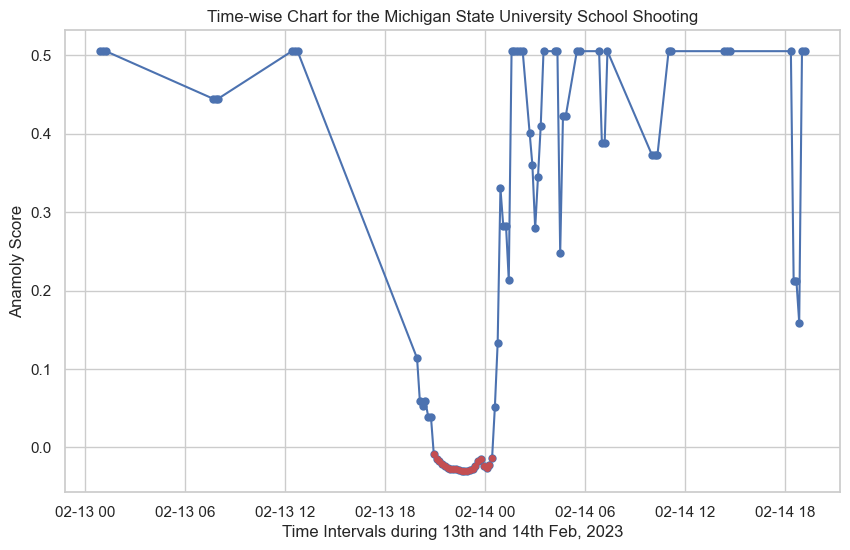

In [149]:
time_intervals = np.array(event_data['start_time'])
anamoly_score = np.array(event_data['anamoly_score'])
outliers = np.array(event_data['anamoly'])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the p-values over time intervals
ax.plot(time_intervals, anamoly_score, marker='o', linestyle='-', color='b',mew=0)


highlight_indices = np.where(np.array(outliers) == -1)[0]

# Highlight the lower p-values
for i in highlight_indices:
    ax.plot(time_intervals[i], anamoly_score[i], marker='o', markersize=5, linestyle='', color='r', mew=0,mec='red')

# Set labels and title
ax.set_xlabel('Time Intervals during 13th and 14th Feb, 2023')
ax.set_ylabel('Anamoly Score')
ax.set_title('Time-wise Chart for the Michigan State University School Shooting')

# Show the plot
plt.show()

Below, is the chart generated by our statistical model.

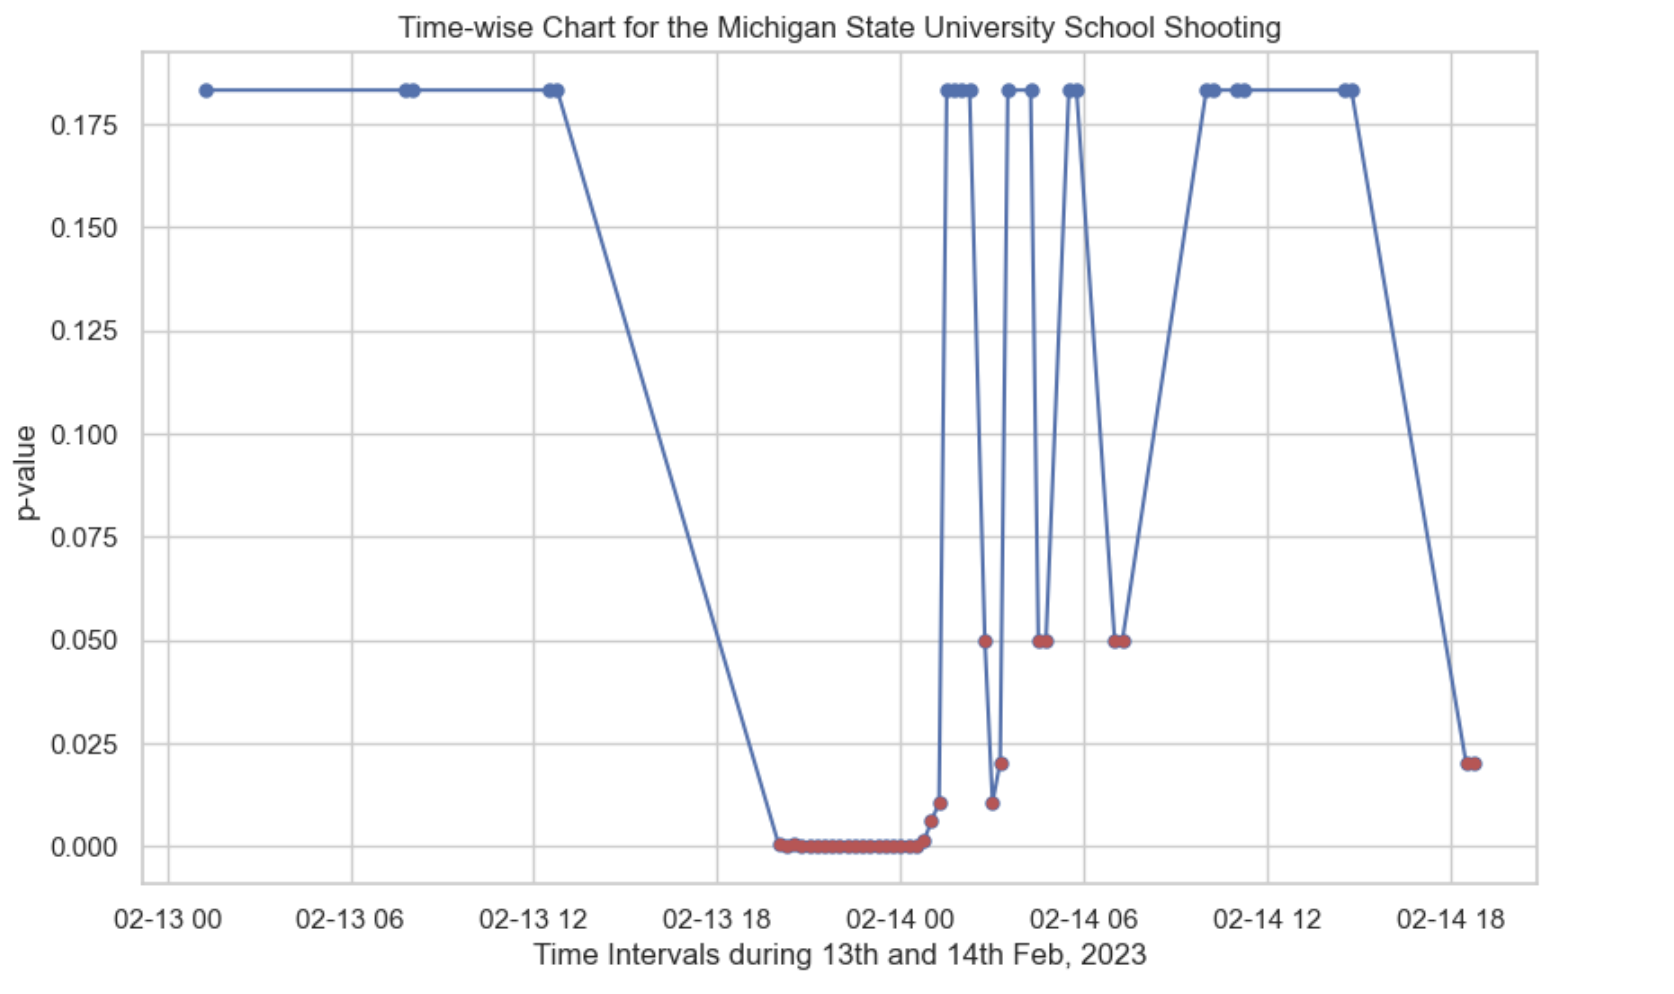

Although the statistical model initially lagged in identifying the events, the isolation forest model efficiently filtered only the shooting-related incidents from over 20,000 30-minute time intervals. This suggests that the isolation forest method could offer a more robust approach, leading to higher confidence in predictions and potentially reducing false negatives. Moreover, a combined utilization of both models may aid in distinguishing between more severe and less severe events based on patterns extracted from 911 call data.




